In [2]:
#!pip install stable-baselines3[extra]

# Python 3.9
# -- Prerequisites install 
%pip install ipykernel --user
%pip install stable_baselines3 --user
%pip install tensorboard --user
%pip install torch --index-url https://download.pytorch.org/whl/cu117 --upgrade --force-reinstall --trusted-host pypi.org --trusted-host pytorch.org --trusted-host download.pytorch.org --no-cache --user


^C


# STABLEBASELINES TESTBED

In [ ]:
# Battery env 
import gymnasium as gym
import numpy as np
from typing import Optional, Union
import itertools



#class BatteryEnv(gym.Env[np.ndarray, Union[int, np.ndarray]]):

class BatteryEnv(gym.Env):

   def __init__(self, nr_batteries, render_mode: Optional[str] = None):
      super().__init__()

      self.env_id = "Battery v0.4"
      self.num_envs = 1
      
      
      self.nr_batteries = nr_batteries


      self.soc_threshold_upper = 0.85
      self.soc_threshold_lower = 0.15


      self.action_space = gym.spaces.Box(-1, 1, (self.nr_batteries,), dtype=np.float32)       # current applied to cell1,cell2,cell3...
      self.observation_space = gym.spaces.Box(0, 1, (self.nr_batteries,), dtype=np.float32)   # SOCs for cell1, cell2, cell3...


      self.episode_time = 0
      self.state = None
      



   def step(self, action):
      err_msg = f"{action!r} ({type(action)}) invalid"
      assert self.action_space.contains(action), err_msg
      assert self.state is not None, "Call reset before using step method."


      battery_current_values = get_converted_action(action)


      self.episode_time += 1
      passed_threshold = False
      terminated = False
      truncated = False

      #Apply action to state
      self.state = np.subtract(self.state, battery_current_values)         

      for soc in self.state:

         if (soc < self.soc_threshold_lower or soc > self.soc_threshold_upper):
            passed_threshold = True
         if (soc < 0 or soc > 100):
            # Sanity check. Should never happen.
            soc = 0.0
            print("//////// EXITED OBSERVATION SPACE BOUNDS ////////  "  + str(soc))



      # Compute reward and termination cases
      reward = 0
      if not passed_threshold and self.episode_time == 128:
         # Apply step reward. Timeout.
         reward = compute_ballancing_reward(self.state, False)

         self.episode_time = 0
         truncated = True

      elif not passed_threshold:
         # Apply step reward. Continue running.
         reward = compute_ballancing_reward(self.state, False)

      
      elif passed_threshold:
         # Batteries drained! Terminated.
         reward = float(-100)
         terminated = True


      # Return modified
      return np.array(self.state, dtype=np.float32), float(reward), terminated, truncated, {}
   

       


   def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,):
        
         super().reset(seed=seed)



         self.episode_time = 0


         # Get random initial state for the episode.
         self.state = self.np_random.uniform(low=0.50, high=0.85, size=(self.nr_batteries,))


         return np.array(self.state, dtype=np.float32), {}



#CONVERT ACTION
   
def get_converted_action(action):
   current_values = []
   for current in action:
      shifted_value = ((current + 1.0) * 5.0)/100.0  #from [-1, 1] to [0, 0.1], to be reduced from SoC
      current_values.append(shifted_value)

   return current_values


# REWARD CALCULATIION HELPERS 

def compute_closeness(socs):
   mean = 0
   for soc in socs:
      mean += soc
   mean = mean/len(socs)

   mean_diff = 0
   for  soc in socs:
      mean_diff += abs(mean - soc)

   mean_diff /= len(socs)

   min = np.array(socs).min()
   max = np.array(socs).max()
   abs_diff_min_max = max - min


   # alternative: (mean_diff_from_mean), or (mean_diff_from_mean*05 + abs_diff_min_max*0.5)
   return abs_diff_min_max





def compute_ballancing_reward(socs, should_print):
   
   #cost as distance between 2 numbers. Yang
   #reward = -pow(soc0 - soc1, 2)

   normalized_socs = []
   for soc in socs:
      newsoc = (soc - min(socs)) / (max(socs) - min(socs))
      normalized_socs.append(newsoc)

   # SOCs are now between [0, 1]
      
   # cost as standard deviation
   # reward = 0.50 - np.std(normalized_socs, dtype=np.float32)
   # reward = -compute_closeness(normalized_socs)
   
   reward = 0

   # Give 0.2 for each pair of SOCs that are within 0.02 distance of eachother.
   for i in range(len(normalized_socs)):
      for j in range(i + 1, len(normalized_socs)):
         if (math.isclose(normalized_socs[i], normalized_socs[j], abs_tol=0.02)):
            reward += 0.2
   
   # Introduce closeness to the reward
   reward = reward - compute_closeness(normalized_socs)
             
   return reward


# Closeness function debug code
numbers = [0.02, 0.05, 0, 0.01, 0.1]
print(compute_closeness(numbers))
print(np.std(numbers, dtype=np.float32))  # standard deviation



0.1
0.036110938
(array([0.52069426, 0.6367162 , 0.54996663, 0.5492705 ], dtype=float32), {})


# PLOTTING FUNCTIONS:

In [2]:
import torch

def plot_step(episode_number, state, action, reward, show_result=False):
    
    fig = plt.figure(1)

    actions_t = torch.tensor(action, dtype=torch.float)
    rewards_t = torch.tensor(reward, dtype=torch.float)

    plt.title('Episode ' + str(episode_number))
    plt.xlabel('Step')
    plt.ylabel('SOC & Actions')



    # Plot SOCs
    soc0 = []
    soc1 = []
    for st in state:
        # states_t = torch.tensor(st, dtype=torch.float)
        # plt.plot(states_t.cpu().squeeze().numpy(), label='State ' + str(st))

        soc0.append(st[0][0].item())
        soc1.append(st[0][1].item())
    
    plt.plot(soc0, label='soc0')
    plt.plot(soc1, label='soc1')



    # Plot actions as indvidual points
    action_array = np.multiply(actions_t.numpy(), 10)   # multiply action values by 10 for better display on graph
    plt.plot(action_array, 'bo', markersize=0.4, label='Action')
    line_nr = 0

    # Plot action value as text above point
    # for line in action_array:
    #     plt.text(line_nr, line+1.8, str(int(line)), horizontalalignment='center', size='small', color='black')
    #     line_nr = line_nr + 1 


    # Plot actions as single point average
    # Take 100 steps average and plot the average action for that period
    # if len(actions_t) >= 10:
    #     means = actions_t.unfold(0, 10, 1).mean(1).view(-1)
    #     means = torch.cat((torch.zeros(9), means))
    #     plt.plot(means.numpy(), 'go', markersize=1, label='Action')

    plt.legend()



    # Plot rewards
    # Reduces displayed rewards by an order of 10 to fit within the graph
    fig2 = plt.figure(2)
    plt.title('Episode ' + str(episode_number))
    plt.xlabel('Step')
    plt.ylabel('Reward')
    #plt.plot(np.divide(rewards_t.numpy(), 10), label='Reward')
    plt.plot(rewards_t.numpy(), label='Reward')

    # add legend with labels
    plt.legend()




    plt.pause(0.0001)  # pause a bit so that plots are updated
    #if is_ipython:
    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())


In [27]:
import matplotlib.pyplot as plt
from IPython import display



def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    # plt.show()

    display.clear_output(wait=True)
    display.display(plt.gcf())


In [28]:
import stable_baselines3

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.env_checker import check_env


#from stable_baselines3 import DQN,PPO,A2C
from stable_baselines3 import PPO
import os


from hyperopt import hp,fmin,tpe
import torch
import math


import numpy as np
from typing import Optional, Union



class PlotResultsCallback(BaseCallback):

    def __init__(self, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.log_dir = log_dir
        self.save_path = None

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        plot_results(log_dir)

        return True
    
    



# Initialize environment

In [29]:
# !pip install gymnasium[box2d]
import gymnasium as gym
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv

from stable_baselines3.common.env_checker import check_env

from stable_baselines3.common.vec_env.vec_monitor import VecMonitor



# Create log dir
log_dir = "./tmp/gym/pponormtest/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = BatteryEnv(4, False)

for i in range(0, 100):
    check_env(env)

# Logs will be saved in log_dir/monitor.csv 
    
env = Monitor(env, log_dir) #monitor for raw environments



# Initialize a new model

In [88]:
from stable_baselines3 import A2C, SAC, PPO, TD3

from stable_baselines3.common.policies import ActorCriticPolicy, BasePolicy, MultiInputActorCriticPolicy


print("Is CUDA enabled?", torch.cuda.is_available())

#  -------------------------------------------------------------  UNUSED  --------------------------------------------------------------------------
# Create action noise because TD3 and DDPG use a deterministic policy
#n_actions = env.action_space.shape[-1]
#action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Create the callback: check every 1000 steps
#callback = SaveOnBestTrainingRewardCallback(check_freq=512, log_dir=log_dir)

# Create RL model
#model = PPO('MlpPolicy', env, verbose=0, device="cuda", tensorboard_log="./ppo_tensorboard_log/", learning_rate=1e-4, gamma=0.20)


# hyperparameters = {
#     'learning_rate': 0.0003,  # Learning rate
#     'n_steps': 2048,  # Number of steps per epoch
#     'batch_size': 256,  # Minibatch size for SGD
#     'ent_coef': 0.01,  # Entropy coefficient for exploration
#     # 'gamma': 0.99,  # Discount factor
#     'gae_lambda': 0.95,  # Lambda coefficient (controls bias-variance trade-off in advantage estimation)
#     'clip_range': 0.2,  # Clip range for PPO clip loss
#     'n_epochs': 4,  # Number of epochs per update
#     'max_grad_norm': 0.5,  # Max norm of gradients
#     'vf_coef': 0.5,  # Value function coefficient in the total loss
#     # 'use_sde': False,  # Whether to use Squashed Diagonal Gaussian policy
#     # 'sde_sample_freq': -1,  # Sample frequency for SDE when `use_sde=True`
# }

# model = PPO('MlpPolicy', env, verbose=0, device="cuda", tensorboard_log="./ppo_tensorboard_log/", policy_kwargs={'net_arch':dict(pi=[256, 256, 256],
#                                                                                                                                  vf=[256, 256, 256])}, **hyperparameters)

#  -------------------------------------------------------------  UNUSED  --------------------------------------------------------------------------


model = PPO('MlpPolicy', env, verbose=0, device="cuda", tensorboard_log="./pponorm_tensorboard_log/")



Is CUDA enabled? True


# Load existing model from save file

In [ ]:
model.load(os.path.join(log_dir, "best_model_ppo_norm/best_mode1"))

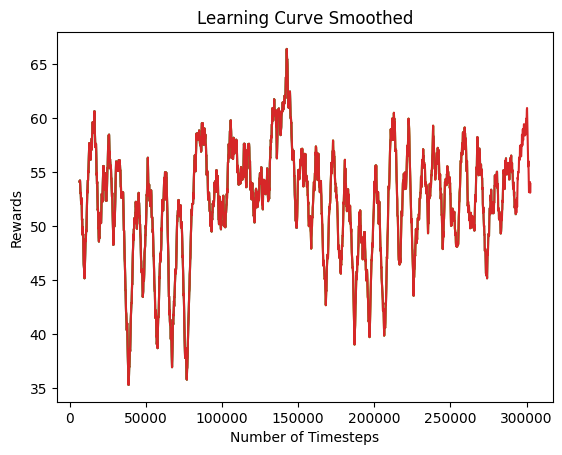

Eval num_timesteps=57600, episode_reward=50.98 +/- 24.08
Episode length: 128.00 +/- 0.00
Eval num_timesteps=60800, episode_reward=48.64 +/- 25.87
Episode length: 128.00 +/- 0.00


KeyboardInterrupt: 

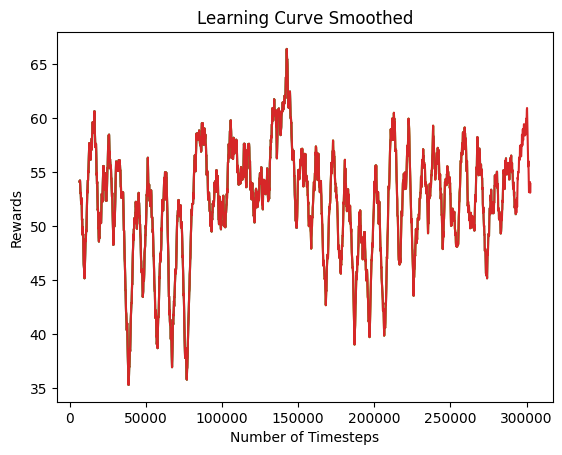

In [38]:
from stable_baselines3.common import results_plotter
from stable_baselines3 import A2C, SAC, PPO, TD3


callback = EvalCallback(env, log_path=log_dir, n_eval_episodes= 50, eval_freq= 25*128, best_model_save_path=os.path.join(log_dir, "best_model_ppo_norm"), callback_on_new_best=PlotResultsCallback(log_dir=log_dir))

model = PPO.load(env=env, path=os.path.join(log_dir, "best_model_ppo_norm300"))
# model.load(os.path.join(log_dir, "best_model_ppo_norm/best_mode1"))


# model.save(os.path.join(log_dir, "best_model_ppo_norm"))

model.learn(total_timesteps=int(300000000000000), callback=callback)


# Helper from the library
results_plotter.plot_results(
    [log_dir], 1e7, results_plotter.X_TIMESTEPS, "PPO - Env: Battery"
)


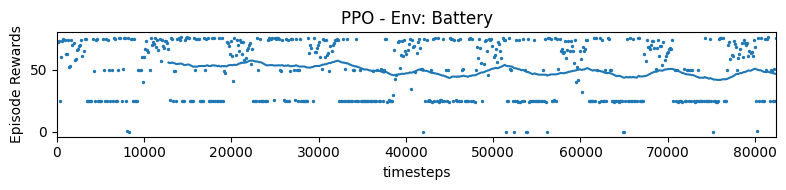

In [32]:
results_plotter.plot_results(
    [log_dir], 1e7, results_plotter.X_TIMESTEPS, "PPO - Env: Battery"
)

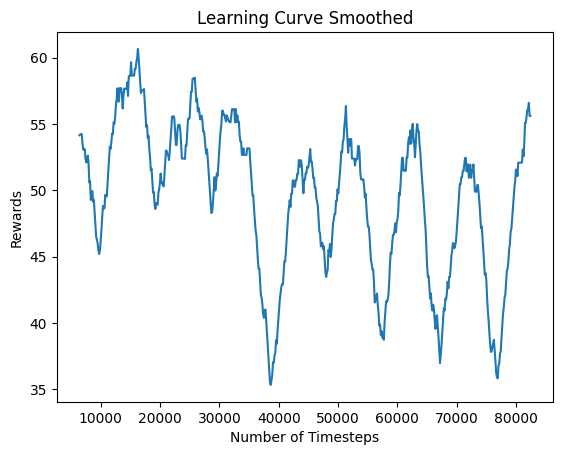

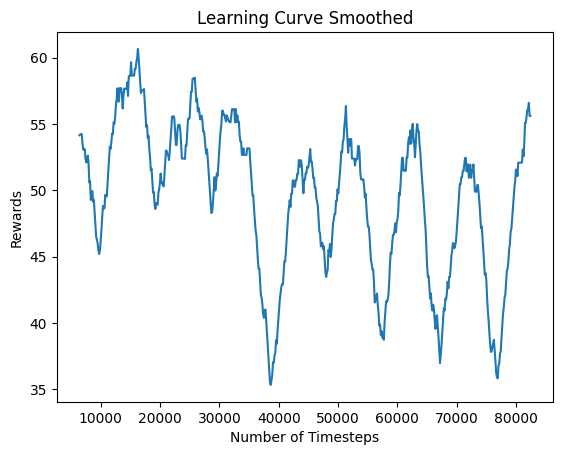

In [34]:

plot_results(log_dir)


# study value and policy more
# view episides during training

[[0.842751  0.607136  0.520143  0.7863996]]  ACTION:[0.1       0.        0.        0.0766006]  >>>> 
[[0.74275106 0.607136   0.520143   0.709799  ]]  REWARD:  [0.]   
[[0.74275106 0.607136   0.520143   0.709799  ]]  ACTION:[0.0718371  0.00734198 0.         0.08165815]  >>>> 
[[0.67091393 0.59979403 0.520143   0.62814087]]  REWARD:  [0.]   
[[0.67091393 0.59979403 0.520143   0.62814087]]  ACTION:[0.04668683 0.0169821  0.         0.1       ]  >>>> 
[[0.6242271  0.5828119  0.520143   0.52814084]]  REWARD:  [0.]   
[[0.6242271  0.5828119  0.520143   0.52814084]]  ACTION:[0.0534138  0.01488575 0.         0.1       ]  >>>> 
[[0.5708133  0.56792617 0.520143   0.42814085]]  REWARD:  [0.]   
[[0.5708133  0.56792617 0.520143   0.42814085]]  ACTION:[0.0276715  0.01755686 0.01620708 0.1       ]  >>>> 
[[0.54314184 0.5503693  0.5039359  0.32814085]]  REWARD:  [0.]   
[[0.54314184 0.5503693  0.5039359  0.32814085]]  ACTION:[0.0324447  0.03389932 0.         0.067765  ]  >>>> 
[[0.5106971  0.51647    

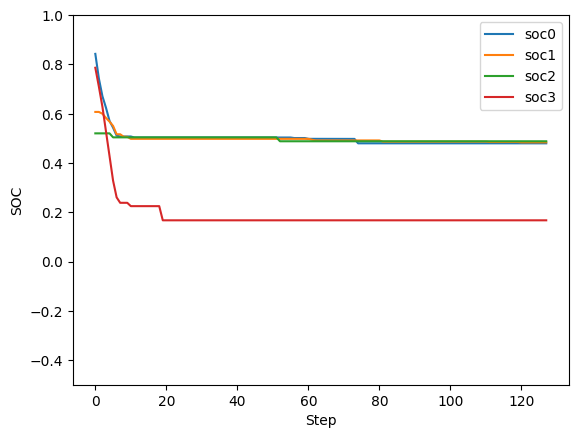

In [37]:

# model.save(os.path.join(log_dir, "best_model_ppo_norm300"))


def test_trained_model():
    obs = model.get_env().reset()
    episode_reward = 0

    obsArray = []

    while True:
        obsArray.append(obs)
        action, _states = model.predict(obs)
        oldObs = obs
        obs, rewards, done, info = model.get_env().step(action)
        episode_reward += rewards.squeeze()

        if not done:
            print(str(oldObs) + "  ACTION:" + str(get_converted_action(action)[0]) + "  >>>> ")
            print(str(obs) + "  REWARD:  "  + str(rewards) + "   ")
        else:
            info_item = info.pop()
            print("FINAL: ")
            print(str(info_item.get('terminal_observation'))  + "       ACTION:" )
            print(str(str(get_converted_action(action.flatten()))))
            print("REWARD:  " + str(rewards[0]))
            print("EPISODE TOTAL REWARD: " + str(episode_reward))

            # plot final model
            fig = plt.figure(1)

            data_np = np.array(obsArray)

            plt.xlabel('Step')
            plt.ylabel('SOC')
            print("------------------------------------------------------")
            plt.ylim([-0.5, 1])


            i = 0
            for soc in data_np.T:
                plt.plot(np.arange(start=0, stop=len(data_np), step=1), soc.flatten(), label="soc"+str(i))
                i += 1

            plt.legend()
            #plt.pause(3)

            obsArray = []
            episode_reward = 0
            obs = model.get_env().reset()

            #time.sleep(0.5)
            break


# def test_paralel_model():

#     env = BatteryEnv(5, False)
#     env = DummyVecEnv([lambda: env])

#     # intialized here
#     obs = env.reset()
    
#     episode_reward = 0
#     obsArray = []

#     while True:
#         action, _states = model.predict(obs)
#         oldObs = obs
#         obs, rewards, done, info = model.get_env().step(action)
#         episode_reward += rewards.squeeze()

#         print(str(oldObs) + "  ACTION:" + str(action) + "  >>>> ")


#         if not done:
#             print(str(oldObs) + "  ACTION:" + str(action) + "  >>>> ")
#             print(str(obs) + "  REWARD:  "  + str(rewards) + "   ")
#         else:
#             info_item = info.pop()
#             print("FINAL: ")
#             print(str(info_item.get('terminal_observation'))  + "       ACTION:" )
#             print(str(str(action.flatten())))
#             print("REWARD:  " + str(rewards[0]))
#             print("EPISODE TOTAL REWARD: " + str(episode_reward))

#             # plot final model
#             fig = plt.figure(1)

#             data_np = np.array(obsArray)

#             plt.xlabel('Step')
#             plt.ylabel('SOC')
#             print("------------------------------------------------------")
#             plt.ylim([-10, 100])


#             i = 0
#             for soc in data_np.T:
#                 plt.plot(np.arange(start=0, stop=len(data_np), step=1), soc.flatten(), label="soc"+str(i))
#                 i += 1

#             plt.legend()
#             #plt.pause(3)

#             obsArray = []
#             episode_reward = 0
#             obs = model.get_env().reset()

#             break




test_trained_model()


In [22]:
# from stable_baselines3.common.monitor import Monitor
# from stable_baselines3.common.vec_env import DummyVecEnv
# from stable_baselines3 import A2C, SAC, PPO, TD3

# env = Monitor(gym.make("Pendulum-v1"))
# env = DummyVecEnv([lambda: env])

# model = A2C("MlpPolicy", env, verbose=1).learn(int(5000))

# BIPEDAL WALKER:

In [13]:
import gymnasium as gym
from stable_baselines3 import A2C, SAC, PPO, TD3



env = gym.make('BipedalWalker-v3')
env.reset()

model = PPO('MlpPolicy', 'BipedalWalker-v3', verbose=1)

TIMESTEPS = 10000

model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name="PPO")

Using cuda device
Creating environment from the given name 'BipedalWalker-v3'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 390      |
|    ep_rew_mean     | -114     |
| time/              |          |
|    fps             | 659      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 419         |
|    ep_rew_mean          | -111        |
| time/                   |             |
|    fps                  | 570         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009753135 |
|    clip_fraction        | 0.0769      |
|

In [23]:
for i in range(1,30):
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name="PPO")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.19e+03 |
|    ep_rew_mean     | 183      |
| time/              |          |
|    fps             | 676      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 824066   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.2e+03     |
|    ep_rew_mean          | 185         |
| time/                   |             |
|    fps                  | 585         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 826114      |
| train/                  |             |
|    approx_kl            | 0.022337046 |
|    clip_fraction        | 0.267       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.396      |
|    explained_variance   | 0.689       |
|    learning_rate        | 0.

KeyboardInterrupt: 

In [39]:
# episodes = 5

# env = gym.make('BipedalWalker-v3') 
# env.reset()

 
env =  gym.make('BipedalWalker-v3',  render_mode='human')
obs = env.reset()[0]

print(obs)

for i in range(1000):
    action, _states = bipedalModel.predict(obs)
    obs, rewards, done, truncated, info= env.step(action)
    env.render()

print()

# for ep in range(episodes):
#     obs = env.reset()
#     done = False
#     total_rewards = 0
#     while not done:
#         action, _states = model.predict(obs[0])
#         print(env.step(action))
#         obs, rewards, done, truncated, info = env.step(action)
#         done = done or truncated
#         total_rewards += rewards
#         env.render()
#     print(total_rewards)

[ 2.7455078e-03  1.2482116e-05 -1.6275706e-03 -1.6000081e-02
  9.2550687e-02  3.7782986e-03  8.5972244e-01 -1.6015018e-03
  1.0000000e+00  3.2850321e-02  3.7781638e-03  8.5350341e-01
 -2.5707902e-03  1.0000000e+00  4.4081330e-01  4.4581941e-01
  4.6142203e-01  4.8954940e-01  5.3410190e-01  6.0246003e-01
  7.0914775e-01  8.8593036e-01  1.0000000e+00  1.0000000e+00]


KeyboardInterrupt: 